# Assignment 3: Use a single feature with different models

### Load full SVHN from HugginFace

In [3]:
# Import hugging face dataset
import huggingface_hub
from datasets import load_dataset

# Import cropped-digits dataset
dataset_cropped_digits_raw = load_dataset("ufldl-stanford/svhn", "cropped_digits")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2

from skimage import color, exposure, filters, util, morphology
from skimage import img_as_ubyte, img_as_float
from skimage.filters import rank
from skimage.filters import gaussian
from sklearn.preprocessing import FunctionTransformer

In [5]:
# Get dataset subsets
ds_train = dataset_cropped_digits_raw["train"]
ds_test = dataset_cropped_digits_raw["test"]

# Get arrays of interest
#labels_train, first_pixel_red_values_train = get_labels_and_pixel_arrays(ds_train)
#labels_test, first_pixel_red_values_test = get_labels_and_pixel_arrays(ds_test)

In [113]:
# Functions

def apply_gaussian_filter(image, sigma=6):
    # Create a Gaussian mask based on distance from the center
    height, width = image.shape
    y, x = np.ogrid[:height, :width]
    center_y, center_x = height / 2, width / 2

    # Create a Gaussian mask
    # sigma = Standard deviation for the Gaussian function
    mask = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))

    # Apply the Gaussian mask to the image
    masked_image = image * mask

    # Scale the masked image to 0-255
    masked_image_scaled = (masked_image - np.min(masked_image)) / (np.max(masked_image) - np.min(masked_image)) * 255
    masked_image_scaled = masked_image_scaled.astype(np.uint8)

    return masked_image_scaled, mask

def remove_borders(image, reduce_factor=0.1):
    # Define the border width as 10% of the image size
    border_size = int(32 * reduce_factor)

    blackout_image = image.copy()
    # Set the border regions to black (0)
    # Top border
    blackout_image[:border_size, :] = 0
    # Bottom border
    blackout_image[-border_size:, :] = 0
    # Left border
    blackout_image[:, :border_size] = 0
    # Right border
    blackout_image[:, -border_size:] = 0

    return blackout_image

def find_contours(image):
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank image to draw contours on
    contour_only_image = np.zeros_like(image)
    cv2.drawContours(contour_only_image, contours, -1, 255, 1)  # Draw contours in white (255)
    return contour_only_image

def sharpen_image(image):
    # Sharpen image
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    return cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

def apply_median_filter(image):
    # Step 2: Reduce the impact of outliers using median filter
    selem = morphology.disk(2)
    return filters.rank.median(img_as_ubyte(image), selem)

def apply_log_filter(image):
    # Create a FunctionTransformer for the log transformation
    log_transformer = FunctionTransformer(np.log1p, validate=True)

    # Apply the log transformation
    transformed_image = log_transformer.fit_transform(image)

    # Rescale the transformed image back to [0, 255]
    transformed_image = (transformed_image / np.max(transformed_image)) * 255
    return transformed_image.astype(np.uint8)

### Extract the train/test datasets

In [105]:
#Interesting: 3, 5, 13, 1082, 1300, 21490, 28689

index = 28689
image = np.array(ds_train[index]["image"])

255.0


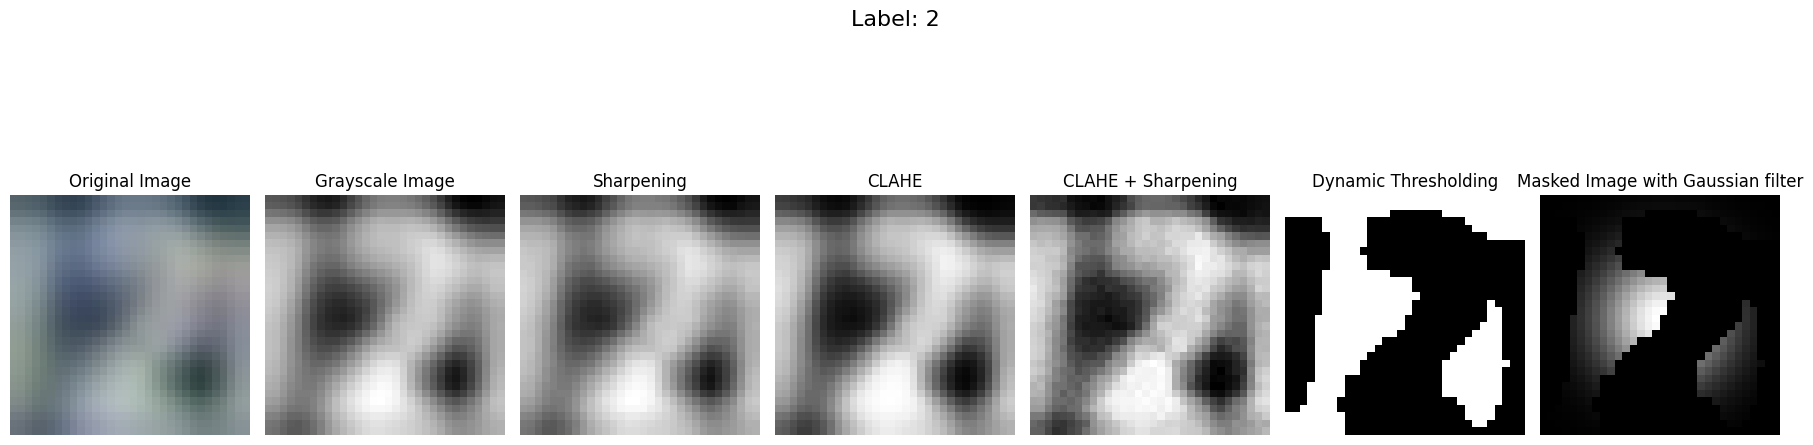

In [ ]:
#chatgpt
def binary_threshold(image, threshold):
    return np.where(image > threshold, 255, 0).astype(np.uint8)

# Step 1: Convert image to grayscale
gray_image = (color.rgb2gray(image) * 255).astype(np.uint8)

# Sharpening
sharpened_image = sharpen_image(gray_image)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1, 1))
clahe_image = clahe.apply(gray_image)

# Apply sharpening on CLAHE result
# Define a sharpening kernel
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
sharpened_clahe_image = cv2.filter2D(clahe_image, -1, sharpen_kernel)

# Median filter
median_filtered_image = apply_median_filter(sharpened_clahe_image)
# Log filter
log_filtered_image = apply_log_filter(median_filtered_image)

# Use binary threshold to reduce everything to 2 colors

_, binary_image = cv2.threshold(sharpened_clahe_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


contour_image = find_contours(binary_image)

# Gaussian filter
masked_image_scaled, mask = apply_gaussian_filter(binary_image)

# Visualization of the steps
fig, axes = plt.subplots(1, 9, figsize=(18, 6))

# Plot each image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title("Grayscale Image")
axes[1].axis('off')

axes[2].imshow(sharpened_image, cmap='gray')
axes[2].set_title("Sharpening")
axes[2].axis('off')

axes[3].imshow(clahe_image, cmap='gray')
axes[3].set_title("CLAHE")
axes[3].axis('off')

axes[4].imshow(sharpened_clahe_image, cmap='gray')
axes[4].set_title("CLAHE + Sharpening")
axes[4].axis('off')

axes[5].imshow(binary_image, cmap='gray')
axes[5].set_title("Dynamic Thresholding")
axes[5].axis('off')

axes[6].imshow(contour_image, cmap='gray')
axes[6].set_title("Contours")
axes[6].axis('off')

axes[7].imshow(mask, cmap='gray')
axes[7].set_title("Gaussian filter")
axes[7].axis('off')

axes[8].imshow(masked_image_scaled, cmap='gray')
axes[8].set_title("Masked Image with Gaussian filter")
axes[8].axis('off')

#
#axes[5].imshow(log_filtered_image, cmap='gray')
#axes[5].set_title("Median + log Image")
#axes[5].axis('off')

plt.suptitle(f'Label: {ds_train[index]["label"]}', fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

plt.tight_layout()
plt.show()

### Common functions

In [56]:
def get_errors(y, y_predict):
    mse = np.mean((y - y_predict)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y - y_predict))

    print(f'MSE:{mse} RMSE:{rmse} MAE:{mae}')

    return mse, rmse, mae

def normalize_background_in_place(images):
    # Assuming images is a NumPy array of shape (N, height, width)
    for i in range(len(images)):
        pre_inversion = images[i]
        if np.mean(images[i]) > 128:  # Threshold to determine background color
            images[i] = 255 - images[i]  # Invert colors in place
            post_inversion = images[i]

            plt.subplot(1, 2, 1)
            plt.title('Pre')
            plt.imshow(pre_inversion, cmap='gray')

            plt.subplot(1, 2, 2)
            plt.title('Post')
            plt.imshow(post_inversion, cmap='gray')
            plt.show()
            print(f'bad_index={i}')

            raise Exception

def create_gaussian_mask(size=(32,32), sigma=6):
    x = np.arange(0, size[0])
    y = np.arange(0, size[1])
    x, y = np.meshgrid(x, y)
    center_x, center_y = size[0] // 2, size[1] // 2
    g = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))
    g /= g.max()  # Normalize
    return g


def remove_side_distractors(ds, labels_ds):
    """ 
    Assumes input dataset are N samples of RGB images, 32x32 (32, 32, 3) shape.
    Input must be a np-array with images only.
    Transforms from RGB (3-channels) to a single grayscale channel
    Applies Gaussian weighting to remove distractions in borders
    Actual digit is centered

    Returns modified dataset
    """
    # Create and normalize Gaussian mask
    gaussian_mask = create_gaussian_mask()

    random_sample_id = random.randint(0, len(ds))
    original_random_image = ds[random_sample_id]

    # Apply the grayscale mask to the image
    grayscale_ds = np.dot(ds[..., :3], [0.299, 0.587, 0.114])
    grayscale_image = grayscale_ds[random_sample_id]

    # Normalize for consistent background
    normalize_background_in_place(grayscale_ds)
    
    grayscale_ds = grayscale_ds[:, :, :, np.newaxis]

    # Apply gaussian mask
    gaussian_mask_and_grayscale_ds = grayscale_ds * gaussian_mask[np.newaxis, :, :, np.newaxis]
    final_image = gaussian_mask_and_grayscale_ds[random_sample_id]

    # Display the results
    plt.figure(figsize=(15, 5))  # Optional: Adjust the figure size

    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(original_random_image, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title('Grayscale Image')
    plt.imshow(grayscale_image, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('Gaussian Mask')
    plt.imshow(gaussian_mask, cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title('Masked Image')
    plt.imshow(final_image, cmap='gray')

    # Set a super title for all subplots
    plt.suptitle(f'Label: {labels_ds[random_sample_id]}', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

    return gaussian_mask_and_grayscale_ds.squeeze(axis=-1)


def get_labels_and_pixel_arrays(ds : object):
    # Need to extract only the data we care about in np arrays
    labels = []
    first_pixel_red_values = []
    ds_sample_size = len(ds)

    for sample in ds:
        labels.append(sample["label"])
        # Convert to RGB
        image_pixel_array = sample["image"].convert('RGB').load()
        # Append Red value of first pixel (0,0)
        first_pixel_red_values.append(image_pixel_array[0,0][0])
    
    # Convert to np
    labels = np.array(labels).reshape(ds_sample_size, 1)
    first_pixel_red_values = np.array(first_pixel_red_values).reshape(ds_sample_size, 1)
    return labels, first_pixel_red_values

In [57]:
def pipeline(ds,
             labels_ds,
             clahe_clipLimit=2.0,
             clahe_tileGridSize=(3,3),
             crop_size=40,
             gaussian_sigma=6
             ):
    """ 
    Assumes input dataset are N samples of RGB images, 32x32 (32, 32, 3) shape.
    Input must be a np-array with images only.
    Transforms from RGB (3-channels) to a single grayscale channel
    Applies Gaussian weighting to remove distractions in borders
    Actual digit is centered

    Returns modified dataset
    """
    # Initialize an array to hold the grayscale images
    new_dataset = np.empty((len(ds), 32, 32), dtype=np.uint8)

    random_sample_id = random.randint(0, len(ds))
    original_random_image = ds[random_sample_id]
    original_random_label = labels_ds[random_sample_id]

    # Step 1: Convert images to grayscale
    gray_images = (color.rgb2gray(ds) * 255).astype(np.uint8)

    # Iterate per-image
    total_images_processed = 0
    for i in range(0, len(gray_images)):
        
        total_images_processed +=1
        gray_image = gray_images[i]

        # Sharpening
        sharpened_image = sharpen_image(gray_image)

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=clahe_clipLimit, tileGridSize=clahe_tileGridSize)
        clahe_image = clahe.apply(sharpened_image)

        # Use binary threshold to reduce everything to 2 colors
        _, binary_image = cv2.threshold(clahe_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Define the crop size
        # Calculate the starting and ending indices for cropping
        start = (32 - crop_size) // 2
        end = start + crop_size

        # Crop the center section of the image
        cropped_image = binary_image[start:end, start:end]
        # Use binary threshold to reduce everything to 2 colors
        _, cropped_image = cv2.threshold(cropped_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Invert image if needed
        #if np.median(cropped_image) > 128:  # Threshold to determine background color
        #    binary_image = 255 - binary_image  # Invert colors in place

        # Gaussian filter
        masked_image_scaled = apply_gaussian_filter(binary_image, gaussian_sigma)

        new_dataset[i] = masked_image_scaled

        # Median filter
        # median_filtered_image = apply_median_filter(clahe_image)
        # Log filter
        # log_filtered_image = apply_log_filter(median_filtered_image)

        if i == random_sample_id:
            # Visualization of the steps
            fig, axes = plt.subplots(1, 6, figsize=(18, 6))

            # Plot each image
            axes[0].imshow(original_random_image, cmap='gray')
            axes[0].set_title("Original Image")
            axes[0].axis('off')

            axes[1].imshow(gray_image, cmap='gray')
            axes[1].set_title("Grayscale Image")
            axes[1].axis('off')

            axes[2].imshow(sharpened_image, cmap='gray')
            axes[2].set_title("Sharpening")
            axes[2].axis('off')

            axes[3].imshow(clahe_image, cmap='gray')
            axes[3].set_title("CLAHE")
            axes[3].axis('off')

            axes[4].imshow(binary_image, cmap='gray')
            axes[4].set_title("Dynamic Thresholding")
            axes[4].axis('off')

            axes[5].imshow(masked_image_scaled, cmap='gray')
            axes[5].set_title("Masked Image with Gaussian filter")
            axes[5].axis('off')

            #
            #axes[5].imshow(log_filtered_image, cmap='gray')
            #axes[5].set_title("Median + log Image")
            #axes[5].axis('off')

            plt.suptitle(f'Label: {original_random_label}, index:{random_sample_id}', fontsize=16)

            # Adjust spacing between subplots
            plt.subplots_adjust(wspace=0.3)

            plt.tight_layout()
            plt.show()

    print(f'procesed: {total_images_processed}')
    return new_dataset

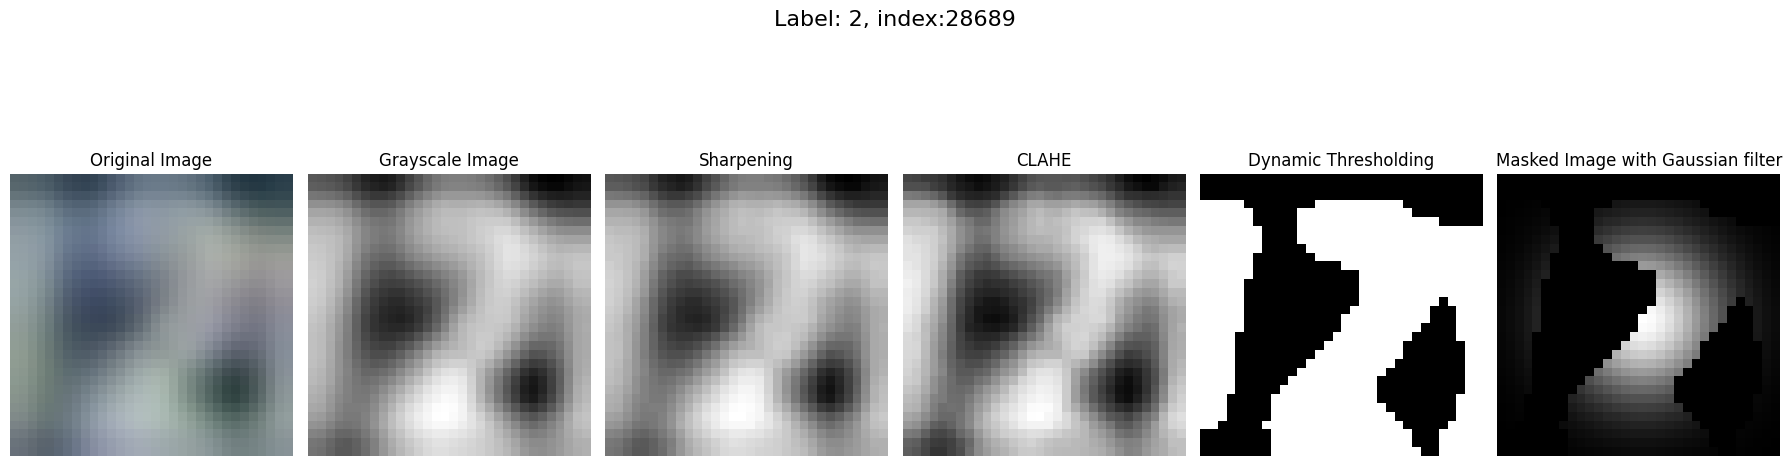

procesed: 73257
(73257, 32, 32)


In [11]:
# Test our processing

ds_train_images = np.array(ds_train["image"])
new_ds_train = pipeline(ds_train_images, ds_train["label"])
print(new_ds_train.shape)

## Flatten images

In [12]:
print(new_ds_train.shape)
new_ds_train = new_ds_train.reshape(new_ds_train.shape[0], -1)
print(new_ds_train.shape)

(73257, 32, 32)
(73257, 1024)


## Use PCA

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_surprise = pca.fit_transform(new_ds_train)
X_surprise.shape

(73257, 2)

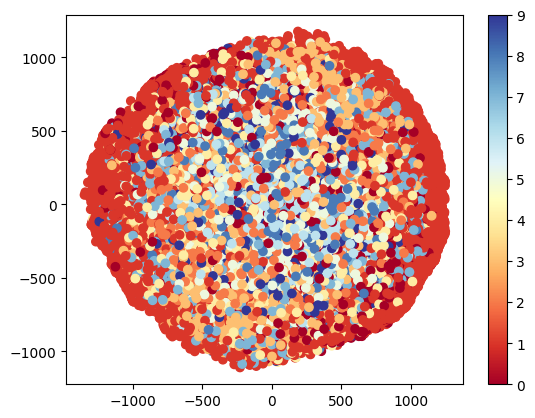

In [14]:
plt.scatter(X_surprise[:, 0], X_surprise[:, 1], c=np.array(ds_train["label"]), cmap='RdYlBu')
plt.colorbar()

### Run with LinearRegression model made on class

In [15]:
class LinearRegressionOwn:
    def __init__(self,
                learning_rate=0.01,
                epochs=100
                ):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        return
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def fit(self, X, y):
        # Define rows (m) and columns/features (n)
        m, n = X.shape

        # Define weights, initially we don't care about it, start with random value
        # Create a single random weight for each feature
        self.weights = np.random.rand(n, 1)
        # Bias is a scalar
        self.bias = np.random.rand(1)

        # Reshape
        y = y.reshape(m, 1)

        # Save losses
        losses_list = list()
        # Save bias
        bias_list = list()
        # Save weights
        weights_list = list()

        # Go over each epoch/iterations

        for epoch in range(self.epochs):

            # calculate prediction
            y_predict = np.dot(X, self.weights) + self.bias

            # get current loss - L - J
            # Mean Square Error, this is how bad our prediction is
            loss = np.mean((y - y_predict)**2)
            # Append the loss
            losses_list.append(loss)

            # calculate gradient
            dw = (-2 / m) * np.dot(X.T, (y-y_predict))
            db = (-2 / m) * np.sum((y-y_predict))

            # update parameters
            self.weights = self.weights - self.learning_rate * dw
            self.bias = self.bias - self.learning_rate * db

            weights_list.append(self.weights)
            bias_list.append(self.bias)

            #print(f'epoch:{epoch:#d} loss:{loss} weights:{self.weights} bias:{self.bias}')

        return self.weights, self.bias, losses_list, bias_list, weights_list

Training

In [16]:
learning_rate = 0.00001
epochs = 50
model = LinearRegressionOwn(learning_rate=learning_rate, epochs=epochs)

weights, bias, losses_list, bias_list, weights_list = model.fit(first_pixel_red_values_train, labels_train)

plt.subplot(1, 3, 1)
plt.plot(np.arange(len(losses_list)), losses_list)
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 3, 2)
plt.scatter(bias_list, losses_list)
plt.xlabel("bias")
plt.ylabel("loss")

plt.subplot(1, 3, 3)
plt.scatter(weights_list, losses_list)
plt.xlabel("weights")
plt.ylabel("loss")

NameError: name 'first_pixel_red_values_train' is not defined

Test prediction

In [ ]:
own_model_prediction = model.predict(first_pixel_red_values_test)
own_model_errors = get_errors(labels_test, own_model_prediction)

### Run with Normal Equation

In [ ]:
X_train_with_bias = np.c_[np.ones((len(first_pixel_red_values_train), 1)), first_pixel_red_values_train]
X_train_with_bias_transposed = X_train_with_bias.T
theta_array = np.linalg.inv(X_train_with_bias_transposed.dot(X_train_with_bias)).dot(X_train_with_bias_transposed).dot(labels_train)

X_test_with_bias = np.c_[np.ones((len(first_pixel_red_values_test),1)), first_pixel_red_values_test]
X_test_with_bias[0:5]

normal_equation_prediction = X_test_with_bias.dot(theta_array)
normal_equation_errors = get_errors(labels_test, normal_equation_prediction)

### Run with SKLEARN

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(first_pixel_red_values_train, labels_train)

sklearn_linear_regression_prediction = model.predict(first_pixel_red_values_test)
sklean_linear_regression_errors = get_errors(labels_test, sklearn_linear_regression_prediction)

# Plot error comparisons between 3 models

In [ ]:
metrics = ['MSE', 'RMSE', 'MAE']
models = ['Own Linear Regression', 'Normal Equation', 'SKLEARN Linear Regression']
colors = ['b', 'g', 'r']

all_errors = np.array([
    own_model_errors,
    normal_equation_errors,
    sklean_linear_regression_errors
])

bar_width = 0.2
index = np.arange(len(metrics))
fig, ax = plt.subplots()

bar_positions = [index + i * bar_width for i in range(len(models))]


for i, model_metrics in enumerate(all_errors):
    ax.bar(bar_positions[i], model_metrics, bar_width, color=colors[i], label=models[i])

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of MSE, RMSE, and MAE for Different Models')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()